# I am a big cheater
# I am stealing code from here:
https://github.com/SamLynnEvans/Transformer


https://github.com/maxjcohen/transformer

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from tqdm.notebook import tqdm
from sklearn.preprocessing import OrdinalEncoder
import random 

import gc
import pickle
import math
import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_squared_error

import time
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader,Dataset
from tqdm import tqdm_notebook as tqdm

device = torch.device('cuda')
# device = torch.device('cpu')

NUM_ITEMS = 30490
DAYS_PRED = 28


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()    

# Make data

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
path = "../data"
calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
# sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_evaluation.csv")) #For final submission

In [ ]:
def prep_calendar(df):
    df = df.drop(["date", "weekday"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    df = df.fillna("missing")
    cols = list(set(df.columns) - {"wm_yr_wk", "d"})
    df[cols] = OrdinalEncoder(dtype="int").fit_transform(df[cols])
    df = reduce_mem_usage(df)
    return df

calendar = prep_calendar(calendar)

In [ ]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    df["sell_price_roll_sd28"] = gr.transform(lambda x: x.rolling(28).std())
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df = reduce_mem_usage(df)
    return df

selling_prices = prep_selling_prices(selling_prices)

In [ ]:
dropd = 509
(1969-dropd)/365 #Will use 4 years dat

In [ ]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i + 1) for i in range(drop_d)], axis=1)
        
    df = df.assign(id=df.id.str.replace("_evaluation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + 28 + i + 1) for i in range(28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int16"))
    return df

sales = reshape_sales(sales, dropd)

# Applying functions in parts

In [ ]:
def long_sale_history_year(df):
    gr = df.groupby(['id'])['demand']
    for year in tqdm(range(1, 4)):
        for d in [-3, -2, -1, 0, 1, 2, 3]: 
            shift = year * 365 + d
            df[f'lag_year_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
    df = reduce_mem_usage(df)    
    return df

sales = long_sale_history_year(sales)

In [ ]:
def long_sale_history_halfyear(df):
    gr = df.groupby(['id'])['demand']
    for year in tqdm(range(1, 4)):
        for d in [-3, -2, -1, 0, 1, 2, 3]: 
            shift = year * (365//2) + d
            df[f'lag_hyear_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
    df = reduce_mem_usage(df)        
    return df

sales = long_sale_history_halfyear(sales)

In [ ]:
def long_sale_history_quarteryear(df):
    gr = df.groupby(['id'])['demand']
    for year in tqdm(range(1, 4)):
        for d in [-3, -2, -1, 0, 1, 2, 3]: 
            shift = year * (365//4) + d
            df[f'lag_qyear_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
    df = reduce_mem_usage(df)         
    return df

sales = long_sale_history_quarteryear(sales)
print(sales.shape)

In [ ]:
# def long_price_history_year(df):
#     gr = df.groupby(['id'])['sell_price']
#     for year in tqdm(range(1, 4)):
#         for d in [-3, -2, -1, 0, 1, 2, 3]: 
#             shift = year * 365 + d
#             df[f'lag_year_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
#     df = reduce_mem_usage(df)    
#     return df

# sales = long_sale_history_year(sales)

# def long_price_history_halfyear(df):
#     gr = df.groupby(['id'])['sell_price']
#     for year in tqdm(range(1, 4)):
#         for d in [-3, -2, -1, 0, 1, 2, 3]: 
#             shift = year * (365//2) + d
#             df[f'lag_year_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
#     df = reduce_mem_usage(df)    
#     return df

# sales = long_price_history_halfyear(sales)

# def long_price_history_quarteryear(df):
#     gr = df.groupby(['id'])['sell_price']
#     for year in tqdm(range(1, 4)):
#         for d in [-3, -2, -1, 0, 1, 2, 3]: 
#             shift = year * (365//4) + d
#             df[f'lag_year_{year}_{d}'] = gr.transform(lambda x: x.shift(shift))
#     df = reduce_mem_usage(df)    
#     return df

# sales = long_sale_history_year(sales)

In [ ]:
!rm temp.hdf

In [ ]:
sales.iloc[-NUM_ITEMS*28*24:].to_hdf("/home/timetraveller/Work/temp_large.hdf", key="ok", index=False)

In [ ]:
!ls *hdf -alh

In [ ]:
# sales.iloc[-NUM_ITEMS*28*12:].to_hdf("temp.hdf", key="ok", index=False)

# Combine

In [ ]:
sales = pd.read_hdf("temp.hdf")

In [ ]:
print(sales.shape)
print(sales.shape[0]//NUM_ITEMS)
sales.head()

In [ ]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.head()

In [ ]:
sales = sales.merge(selling_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
sales.head()

In [ ]:
del selling_prices; gc.collect()

In [ ]:
cat_id_cols = ["item_id", "dept_id", "store_id", "cat_id", "state_id"]
cat_cols = cat_id_cols + ["wday", "month", "year", "event_name_1", 
                          "event_type_1", "event_name_2", "event_type_2"]

for i, v in tqdm(enumerate(cat_id_cols)):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]])

sales = reduce_mem_usage(sales)
gc.collect()
sales.head()

In [ ]:
num_cols_price = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_roll_sd28", "sell_price_cumrel"]

lag_cols = []
for lag in  ['year', 'hyear', 'qyear']:
    for y in range(1, 4):
        for t in [-3, -2, 1, 0, 1, 2,  3]:
            lag_cols.append(f"lag_{lag}_{y}_{t}")

bool_cols = ["snap_CA", "snap_TX", "snap_WI"]

cont_cols = num_cols_price + lag_cols + bool_cols

for i, v in enumerate(tqdm(cont_cols)):
    sales[v] = sales[v].fillna(sales[v].median())
    
sales.head()

In [ ]:
sales.to_hdf("/home/timetraveller/Work/sales.hdf", key="ok", index=False)
# sales= pd.read_hdf("/home/timetraveller/Work/sales.hdf")

In [ ]:
def make_data(i, days, sales, train=False):
    if train: start = 0 
    else: start = (days + i*28)*NUM_ITEMS
    end = i*28*NUM_ITEMS
    print(start)
    print(end)
    if i == 0:
        return sales.iloc[-start:]
    return sales.iloc[-start:-end]

In [ ]:
e_days = 28*4
d_days = 28
days = e_days + d_days
test = make_data(0, days, sales)
val = make_data(1, days, sales)
train = make_data(2, days, sales, True)

In [ ]:
print(train.shape)
print(train.shape[0]/NUM_ITEMS)

print(val.shape)
print(val.shape[0]/NUM_ITEMS)

print(test.shape)
print(test.shape[0]/NUM_ITEMS)

In [ ]:
print(">> train")
for col in train.columns:
    if train[col].isna().any():
        print(col)
        
print(">> val")
for col in val.columns:
    if val[col].isna().any():
        print(col)    
        
print(">> test")
for col in test.columns:
    if test[col].isna().any():
        print(col)    

In [ ]:
import pickle
def save(x, fname):
    with open(fname, "wb") as handle:
        pickle.dump(x, handle)
        
save(train, "train_all.data")        
save(val, "val.data")        
save(test, "test.data")        

# Load data

In [2]:
def load(fname):
    with open(fname, "rb") as handle:
        return pickle.load(handle)
    
# train = load("train.data")    
train = load("train_all.data")    
val = load("val.data")    
test = load("test.data")    

In [3]:
# save(train, "train.data")        
# save(test, "test.data")        

In [4]:
id_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id']
cat_cols = ['wday', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

num_cols_price = ["sell_price", "sell_price_rel_diff", "sell_price_roll_sd7", "sell_price_roll_sd28", "sell_price_cumrel"]

lag_cols = []
for lag in  ['year', 'hyear', 'qyear']:
    for y in range(1, 4):
        for t in [-3, -2, 1, 0, 1, 2,  3]:
            lag_cols.append(f"lag_{lag}_{y}_{t}")

bool_cols = ["snap_CA", "snap_TX", "snap_WI"]

cont_cols = num_cols_price + bool_cols

print(f"# Cat cols: {len(cat_cols)}")
print(f"# Id cols: {len(id_cols)}")
print(f"# Cont cols: {len(cont_cols)}")
print(f"# Lag cols: {len(lag_cols)}")

# Cat cols: 5
# Id cols: 5
# Cont cols: 8
# Lag cols: 63


In [5]:
print("Min max scaling cont and lag data.....")
for col in tqdm(cont_cols + lag_cols):
    maxval = train[col].max()
    minval = train[col].min()
    if maxval == minval:
        denom = 1
    else:
        denom = maxval-minval
    
    train[col] = (train[col]-minval)/denom
    val[col] = (val[col]-minval)/denom
    test[col] = (test[col]-minval)/denom
    gc.collect()    

Min max scaling cont and lag data.....


In [6]:
TARGET = 'demand'
print(train.shape[0]//NUM_ITEMS)
print(val.shape[0]//NUM_ITEMS)
print(test.shape[0]//NUM_ITEMS)

280
140
140


In [7]:
# Sanity check
print(">> train")
for col in train.columns:
    if train[col].isna().any():
        print(col)
        
print(">> val")
for col in val.columns:
    if val[col].isna().any():
        print(col)    
        
print(">> test")
for col in test.columns:
    if test[col].isna().any():
        print(col)    

>> train
>> val
>> test
demand


# DataLoader

In [8]:
import os
from torch.utils.data import TensorDataset, DataLoader,Dataset

class M5Dataset_train(Dataset):
    def __init__(self, X, cont_cols, cat_cols, id_cols, lag_cols, 
                             target='demand', e_days=28*4, d_days=28):
        
        self.e_days = e_days
        self.d_days = d_days
        cat_cols = id_cols + cat_cols 
        self.cat_cols = cat_cols
        
        self.X_cont = X[cont_cols].values
        self.X_cat = X[cat_cols].values
        self.X_lags = X[lag_cols].values
        self.ids = X[id_cols].values
        self.y = X[target].values
        
        x_days = X.shape[0]//NUM_ITEMS
        total_days = x_days - e_days - d_days
        self.len = int(NUM_ITEMS * total_days)
        self.total_days = total_days
        print(f"total_days: {total_days}")
        print(f"len: {self.len}")

    def get_ti(self, idx):
        time, item = divmod(idx, NUM_ITEMS)
        return time, item
    
    def __getitem__(self, idx):
        time, item = self.get_ti(idx)
        e_start_day = time
        e_end_day = time + self.e_days
        d_start_day = time + self.e_days
        d_end_day = time + self.e_days + self.d_days
        
        e_idxes = item + np.arange(e_start_day, e_end_day)*NUM_ITEMS
        d_idxes = item + np.arange(d_start_day, d_end_day)*NUM_ITEMS

        #Encoding cat and cont information
        encoder_cont = np.concatenate([self.X_cont[e_idxes],
                                                                          self.y[e_idxes].reshape(-1, 1)], 
                                                                          axis=1)
        encoder_cat = self.X_cat[e_idxes]
        encoder_lags = self.X_lags[e_idxes]
        enc_hist = self.y[e_idxes]
        
        #Decoding cat and cont information
        decoder_cont = self.X_cont[d_idxes]
        decoder_cat = self.X_cat[d_idxes]
        decoder_lags = self.X_lags[d_idxes]
        
        #Labels
        labels = self.y[d_idxes]
        #Id (same for all timesteps)
        ids = self.ids[idx]
        return (enc_hist, encoder_cont, encoder_cat, encoder_lags, 
                        decoder_cont, decoder_cat, decoder_lags), idx, labels

    def __len__(self):
        return self.len

    def __repr__(self):
        return "e_cont, e_cat, d_cont, d_cat, ids, y"

In [9]:
class M5Dataset(Dataset):
    def __init__(self, X, cont_cols, cat_cols, id_cols, lag_cols, 
                             target='demand', e_days=28*4, d_days=28):
        
        self.e_days = e_days
        self.d_days = d_days
        cat_cols = id_cols + cat_cols 
        self.cat_cols = cat_cols
        
        self.X_cont = X.iloc[-NUM_ITEMS*(e_days+d_days):][cont_cols].values
        self.X_cat = X.iloc[-NUM_ITEMS*(e_days+d_days):][cat_cols].values
        self.X_lags = X.iloc[-NUM_ITEMS*(e_days+d_days):][lag_cols].values
        self.ids = X.iloc[-NUM_ITEMS*(e_days+d_days):][id_cols].values
        self.y = X.iloc[-NUM_ITEMS*(e_days+d_days):][target].values
        
        self.len = NUM_ITEMS

    def __getitem__(self, idx):
        item = idx
        e_start_day = 0
        e_end_day = self.e_days
        d_start_day = self.e_days
        d_end_day = self.e_days  + self.d_days      
        
        
        e_idxes = item + np.arange(e_start_day, e_end_day)*NUM_ITEMS
        d_idxes = item + np.arange(d_start_day, d_end_day)*NUM_ITEMS

        #Encoding cat and cont information
        encoder_cont = np.concatenate([self.X_cont[e_idxes],
                                                                          self.y[e_idxes].reshape(-1, 1)], 
                                                                          axis=1)
        encoder_cat = self.X_cat[e_idxes]
        encoder_lags = self.X_lags[e_idxes]
        enc_hist = self.y[e_idxes]
        
        #Decoding cat and cont information
        decoder_cont = self.X_cont[d_idxes]
        decoder_cat = self.X_cat[d_idxes]
        decoder_lags = self.X_lags[d_idxes]
        
        #Labels
        labels = self.y[d_idxes]
        #Id (same for all timesteps)
        ids = self.ids[idx]
        return (enc_hist, encoder_cont, encoder_cat, encoder_lags, 
                        decoder_cont, decoder_cat, decoder_lags), idx, labels

    def __len__(self):
        return self.len

    def __repr__(self):
        return "e_cont, e_cat, d_cont, d_cat, ids, y"

In [10]:
bs = 128
shuffle = True
num_workers = 4
e_days = 28*4 #Can't be more than 28*4 for now
d_days = 28


train_dataset = M5Dataset_train(train, cont_cols, cat_cols, id_cols, lag_cols, 
                                                 e_days=e_days, d_days=d_days)

train_loader = DataLoader(train_dataset, batch_size=bs,
                                    shuffle=shuffle, num_workers=num_workers)

val_dataset = M5Dataset(val, cont_cols, cat_cols, id_cols, lag_cols, 
                                                 e_days=e_days, d_days=d_days)

val_loader = DataLoader(val_dataset, batch_size=bs,
                                    shuffle=False, num_workers=num_workers)

total_days: 140
len: 4268600


In [11]:
print("Train")
print(len(train_dataset))
print(len(train_loader))

for i, (x, idx, y) in enumerate(train_loader):
    for _x in x:
        print(_x.shape)
    print(idx)    
    break
    
print("\nVal")
print(len(val_dataset))
print(len(val_loader))

for i, (x, idx, y) in enumerate(val_loader):
    for _x in x:
        print(_x.shape)
    print(idx)    
    break    

Train
4268600
33349
torch.Size([128, 112])
torch.Size([128, 112, 9])
torch.Size([128, 112, 10])
torch.Size([128, 112, 63])
torch.Size([128, 28, 8])
torch.Size([128, 28, 10])
torch.Size([128, 28, 63])
tensor([2505276, 2424199, 2201900, 2167290, 1523832, 2294929, 4194292, 2507456,
        4091034, 2529923, 1889000,  370847, 2258095, 3290940, 3543385, 3200655,
        1916775, 3891441, 3038127, 3245359, 3865593, 1972778, 2514135, 1516548,
        2782877, 3344794, 4051845, 1480392, 2299152, 1280318,  528085, 1860425,
           7861,  469628, 2632129,  875416,  130416,   88783, 2722594, 1428339,
        1523217, 4073846, 4064255, 3330863, 2683579,  903469, 3808007,  713401,
         149038,  909036, 3882420, 3538974, 1780822, 1351569,  347853, 2783834,
        3150010, 1126270, 1306162, 2216645, 2475260, 1231454, 1939562, 1481643,
        3249043,  154605, 2611563, 3314850, 1723729, 3429861, 2136074,  278160,
        1182876, 1383218, 2012669, 2213532, 3753026, 2119267, 3390608, 3312397,


In [12]:
# for i, (x, idx, y) in enumerate(tqdm(train_loader)):
#     continue

# Losses

In [13]:
calc_wrmsse = True

class MSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        y_true = y_true.type(torch.FloatTensor).to(device).flatten()
        y_pred = y_pred.flatten()
        return self.mse(y_pred, y_true)

class RMSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        y_true = y_true.type(torch.FloatTensor).to(device).flatten()
        y_pred = y_pred.flatten()
        return torch.sqrt(self.mse(y_pred, y_true))    
    
class Assymetric_RMSE(nn.Module):
    def __init__(self, penalty=3.5):
        super().__init__()
        self.mse = nn.MSELoss()
        self.penalty = penalty
        
    def forward(self, y_pred, y_true):
        y_true = y_true.type(torch.FloatTensor).to(device).flatten()
        y_pred = y_pred.flatten()
        error = torch.where(y_true==0, self.penalty*(y_true-y_pred)**2, (y_true-y_pred)**2)
        return torch.sqrt(torch.mean(error))

class MAE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        y_true = y_true.type(torch.FloatTensor).to(device).flatten()
        y_pred = y_pred.flatten()
        return torch.mean(torch.abs(y_pred-y_true))        
    
if calc_wrmsse:
    roll_mat_df = pd.read_pickle('../data/roll_mat_df.pkl')
    roll_index = roll_mat_df.index
    roll_mat_csr = csr_matrix(roll_mat_df.values)
    del roll_mat_df; gc.collect()

    sw_df = pd.read_pickle('../data/sw_df.pkl')
    s = sw_df.s.values
    w = sw_df.w.values
    sw = sw_df.sw.values   
    
def rollup(v, roll_mat_csr):
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T

def wrmsse_metric(preds, y_true, score_only=True, npy=True, roll_mat_csr=None, sw=None, roll_index=roll_index, verbose=False, s=s, w=w):
    preds = np.array(preds).reshape(NUM_ITEMS, -1)
    y_true = np.array(y_true).reshape(NUM_ITEMS, -1)

    if roll_mat_csr is None:
        roll_mat_df = pd.read_pickle('../data/roll_mat_df.pkl')
        roll_index = roll_mat_df.index
        roll_mat_csr = csr_matrix(roll_mat_df.values)
        del roll_mat_df; gc.collect()

    if sw is None:
        sw_df = pd.read_pickle('../data/sw_df.pkl')
        s = sw_df.s.values
        w = sw_df.w.values
        sw = sw_df.sw.values

    if not npy:
        preds = preds.values
        y_true = y_true.values
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds-y_true, roll_mat_csr))
                            ,axis=1)) * sw)/12 
    else: 
        score_matrix = (np.square(rollup(preds-y_true, roll_mat_csr)) * np.square(w)[:, None])/ s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix, axis=1)))/12 
        
        score_df = pd.DataFrame(score_matrix, index = roll_index)
        score_df.reset_index(inplace=True)
        score_df['mean_err'] = score_df.mean(axis=1)
        level_wise_error1 = score_df.groupby('level')['mean_err'].mean()
        
        return score, level_wise_error1.values

def rmse_metric(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.sqrt(np.mean((y_pred-y_true)**2))                                

def rmse_metric_npy(y_pred, y_true):
    return np.sqrt(np.mean((y_pred-y_true)**2))  

In [14]:
class WRMSSE(nn.Module):
    def __init__(self, roll_mat_csr=roll_mat_csr, sw=sw):
        super().__init__()
        roll_mat_coo = roll_mat_csr.tocoo()
        self.rollTensor = torch.sparse.LongTensor(torch.LongTensor([roll_mat_coo.row.tolist(), roll_mat_coo.col.tolist()]),
                              torch.LongTensor(roll_mat_coo.data.astype(np.int32))).type(torch.FloatTensor).to_dense()
        self.sw_t = torch.FloatTensor(sw).to(device)

    def forward(self, y_pred, y_true, idxes):
        _bs = y_true.shape[0]
        idxes = list(idxes.numpy())
        y_true = y_true.type(torch.FloatTensor).to(device).flatten().view(_bs, -1)
        y_pred = y_pred.flatten().view(_bs, -1)
        
        residual = y_true-y_pred
        
        loss = torch.sum(torch.sqrt(
                    torch.mean((
                        torch.mm(self.rollTensor[:, idxes].to(device), residual)**2), axis=1)+1e-8 
                    )*self.sw_t)/12        
        return 1e4*loss #Dont want gradients too small  

In [15]:
class WeightedRoll_MSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.sw_t = torch.FloatTensor(sw[:, np.newaxis]).to(device)
        roll_mat_coo = roll_mat_csr.tocoo()
        self.rollTensor = torch.sparse.LongTensor(torch.LongTensor([roll_mat_coo.row.tolist(), roll_mat_coo.col.tolist()]),
                              torch.LongTensor(roll_mat_coo.data.astype(np.int32))).type(torch.FloatTensor).to_dense()
        
    def rollup(self, x):
        return torch.mm(self.rollTensor, x)
        
    def forward(self, y_pred, y_true, i):
        _bs = y_true.shape[0]
        idxes = np.arange(i*bs, i*bs+_bs)
        
        y_true = y_true.type(torch.FloatTensor).to(device).flatten().view(_bs, -1)
        y_pred = y_pred.flatten().view(_bs, -1)
        
        error1 = self.mse(y_pred, y_true)
        partial_roll_t = self.rollTensor[:, idxes].to(device)
        
        y_pred = torch.mm(partial_roll_t, y_pred)
        y_true = torch.mm(partial_roll_t, y_true)
        y_pred = (self.sw_t*y_pred).flatten()
        y_true = (self.sw_t*y_true).flatten()
        error2 = 1e8*self.mse(y_pred, y_true)
        
        return error1 + error2 #Dont want gradients to be too small

In [16]:
class RMSE_summed(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
    
    def forward(self, y_pred, y_true):
        y_true = y_true.type(torch.FloatTensor).to(device).flatten()
        y_pred = y_pred.flatten()
        n = y_true.shape[0]+1 #1 for sum of all        
        error1 = self.mse(y_true, y_pred)
        true_sum = torch.sum(y_true)
        pred_sum = torch.sum(y_pred)
        residual = torch.abs(true_sum-pred_sum)
        error2 = residual/n
        
#         error1 = torch.sum((torch.log1p(y_true) - torch.log1p(y_pred))**2)/n
#         error2 = (torch.log1p(torch.sum(y_true)) - torch.log1p(torch.sum(y_pred)))**2/n
        return error1 + error2

# Model

In [17]:
from tst.encoder import Encoder
from tst.decoder import Decoder
from tst.utils import generate_original_PE, generate_regular_PE

In [18]:
# uniques = [3049, 7, 10, 3, 3, 7, 31, 5, 5, 5]
# # dims = [5, 1, 2, 1, 1, 1, 2, 1, 1, 1]
# dims = [7, 2, 3, 1, 1, 1, 3, 1, 1, 1]
# emb_dims = [(x, y) for x, y in zip(uniques, dims)]
# print(emb_dims)

In [19]:
uniques = [3049, 7, 10, 3, 3, 7, 31, 5, 5, 5]
# dims = [5, 1, 2, 1, 1, 1, 2, 1, 1, 1]
dims = [16, 2, 3, 1, 1, 2, 4, 2, 2, 2]
emb_dims = [(x, y) for x, y in zip(uniques, dims)]
print(emb_dims)

[(3049, 16), (7, 2), (10, 3), (3, 1), (3, 1), (7, 2), (31, 4), (5, 2), (5, 2), (5, 2)]


In [36]:
class ConvModule(nn.Module):
    def __init__(self, seq_len=56):
        super().__init__()
        self.seq_len = seq_len
        
        self.global_conv = nn.Conv1d(1, 2, kernel_size=(seq_len))
        self.week_conv = nn.Conv1d(1, 1, kernel_size=(7))
        self.last_week_conv = nn.Conv1d(1, 1, kernel_size=(7))
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x[:, None, :] #insert 1 channel (bs, channel, timesteps)
        bs = x.shape[0]
        
        out1 = self.global_conv(x).view(bs, -1).view(bs, -1)
        out1 = self.drop(out1)
        
        out2 = self.week_conv(x).view(bs, -1).view(bs, -1)
        out2 = self.drop(out2)
        
        out3 = self.last_week_conv(x[:, :, -7:]).view(bs, -1)
        out3 = self.drop(out3)     
        
        out = torch.cat([out1, out2, out3], axis=1)
        return out

class M5Transformer(nn.Module):
    def __init__(self,
                 d_input: int,
                 d_model: int,
                 d_output: int,
                 q: int,
                 v: int,
                 h: int,
                 N_e: int,
                 N_d: int,
                 n_months: int,
                 attention_size: int = None,
                 dropout: float = 0.3,
                 chunk_mode: bool = True,
                 pe: str = None,
                 n_lag_convs=3,
                 e_days = 28*4,
                 d_days = 28):
        
        super().__init__()
        
        self._d_model = d_model
        self._inp_dropout = nn.Dropout(0.1)

        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])
        self._lag_per_time = nn.Linear(63, n_lag_convs)
        
        self._e_inp_norm = nn.LayerNorm(d_input+n_lag_convs)
        self._d_inp_norm = nn.LayerNorm(d_input+n_lag_convs-1)

        self._embedding = nn.Linear(d_input, d_model)
        
        self.enc_embedding = nn.Linear(d_input+n_lag_convs, d_model)
        self.dec_embedding = nn.Linear(d_input-1+n_lag_convs, d_model)
        
        self.layers_encoding = nn.ModuleList([Encoder(d_model,
                                                      q,
                                                      v,
                                                      h,
                                                      attention_size=attention_size,
                                                      dropout=dropout,
                                                      chunk_mode=chunk_mode) for _ in range(N_e)])
        
        self.layers_decoding = nn.ModuleList([Decoder(d_model,
                                                      q,
                                                      v,
                                                      h,
                                                      n_months,
                                                      attention_size=attention_size,
                                                      dropout=dropout,
                                                      chunk_mode=chunk_mode) for _ in range(N_d)])

        self.hist_covs = ConvModule(e_days)
        out_dim = 237
        self.out = nn.Sequential(
                                        nn.Linear(out_dim, out_dim//2),
                                        nn.LeakyReLU(),
                                        nn.LayerNorm(out_dim//2),
                                        nn.Linear(out_dim//2, d_output),
                                    )
        
#         self.out = nn.Linear(out_dim, d_output)
        
        pe_functions = {
            'original': generate_original_PE,
            'regular': generate_regular_PE,
        }

        if pe in pe_functions.keys():
            self._generate_PE = pe_functions[pe]
        elif pe is None:
            self._generate_PE = None
        else:
            raise NameError(
                f'PE "{pe}" not understood. Must be one of {", ".join(pe_functions.keys())} or None.')

#     def lag_features(self, lag):
#         bs, t, nf = lag.shape
#         lag_features = []        
#         for i in range(t):
#                 _x = lag[:, i, :].reshape(bs, nf, -1)
#                 feats = [lc(_x) for lc in self._lag_convs]
#                 lag_features.append(torch.cat(feats, dim=2))
#         return torch.cat(lag_features, dim=1)
                
    def embed_and_combine(self, cont, cat, lag):
        cat = cat.type(torch.LongTensor).to(device)
        cont = cont.type(torch.FloatTensor).to(device)
        lag = lag.type(torch.FloatTensor).to(device)                
        xcat = [el(cat[:, :, k]) for k, el in enumerate(self.emb_layers)]
        xcat = torch.cat(xcat, axis=2)
        xlags = self._lag_per_time(lag)        
        combined = torch.cat([xcat, cont, xlags], axis=2) 
        combined = self._inp_dropout(combined)  
        return combined 

                
    def forward(self, x):
        hist, e_cont, e_cat, e_lag, d_cont, d_cat, d_lag = x        
                
        encoder_input = self.embed_and_combine(e_cont, e_cat, e_lag) #(bs, etime, d_inp)
        encoder_input = self._e_inp_norm(encoder_input)
        decoder_input = self.embed_and_combine(d_cont, d_cat, d_lag) #(bs, etime, d_inp-1)
        decoder_input = self._d_inp_norm(decoder_input)
                
        bs = encoder_input.shape[0]         
        Ke = encoder_input.shape[1]
        Kd = decoder_input.shape[1]

        # Embedding module
        encoding = self.enc_embedding(encoder_input)        

        # Add position encoding
        if self._generate_PE is not None:
            positional_encoding = self._generate_PE(Ke, self._d_model)
            positional_encoding = positional_encoding.to(encoding.device)
            encoding.add_(positional_encoding)

        # Encoding stack
        for layer in self.layers_encoding:
            encoding = layer(encoding)

        # Decoding stack
        decoding = self.dec_embedding(decoder_input)        
#         decoding = encoding        

        # Add position encoding
        if self._generate_PE is not None:
            positional_encoding = self._generate_PE(Kd, self._d_model)
            positional_encoding = positional_encoding.to(decoding.device)
            decoding.add_(positional_encoding)
                
        for layer in self.layers_decoding:
            decoding = layer(decoding, encoding)

        # Output module
        _hist = self.hist_covs(hist.type(torch.FloatTensor).to(device))       
        _hist = _hist.unsqueeze(1).repeat(1, 28, 1)        
        output = self.out(torch.cat([decoding, _hist], 2))
#         output = F.relu(output)
        return output.reshape(bs, -1)

In [37]:
d_input = 44 
d_model = 64 
d_output = 1
q = 8  
v = 8  
h = 1 # Number of heads
N_e = 2 # Number of encoders to stack
N_d = 1 # Number of decoders to stack
attention_size = 12  
n_months = e_days // d_days
dropout = 0.2 
# pe = 'original'
pe = None
chunk_mode = None
n_lag_convs = 9 #over 63 past lags

In [38]:
# criterion = RMSE()
# criterion = WRMSSE()
# criterion = Assymetric_RMSE(penalty=3.5)
# criterion = WeightedRoll_MSE()
model = M5Transformer(d_input, d_model, d_output, q, v, h, N_e, N_d, n_months, attention_size=attention_size,
                  dropout=dropout, chunk_mode=chunk_mode, pe=pe, n_lag_convs=n_lag_convs, e_days=e_days,
                     d_days=d_days).to(device)

In [39]:
model

M5Transformer(
  (_inp_dropout): Dropout(p=0.1, inplace=False)
  (emb_layers): ModuleList(
    (0): Embedding(3049, 16)
    (1): Embedding(7, 2)
    (2): Embedding(10, 3)
    (3): Embedding(3, 1)
    (4): Embedding(3, 1)
    (5): Embedding(7, 2)
    (6): Embedding(31, 4)
    (7): Embedding(5, 2)
    (8): Embedding(5, 2)
    (9): Embedding(5, 2)
  )
  (_lag_per_time): Linear(in_features=63, out_features=9, bias=True)
  (_e_inp_norm): LayerNorm((53,), eps=1e-05, elementwise_affine=True)
  (_d_inp_norm): LayerNorm((52,), eps=1e-05, elementwise_affine=True)
  (_embedding): Linear(in_features=44, out_features=64, bias=True)
  (enc_embedding): Linear(in_features=53, out_features=64, bias=True)
  (dec_embedding): Linear(in_features=52, out_features=64, bias=True)
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=64, out_features=8, bias=True)
        (_W_k): Linear(in_features=64, out_features=8, bias=True)
      

In [40]:
# criterion = WRMSSE()
criterion = RMSE()
for i, (x, idx, y) in enumerate(train_loader):
    out = model(x)
#     loss = criterion(out, y, idx)
    loss = criterion(out, y)
    loss.backward()
    break
print(loss)    
print(out)

tensor(3.6505, device='cuda:0', grad_fn=<SqrtBackward>)
tensor([[ 0.0050,  0.4040,  0.4009,  ...,  0.0900,  0.4664,  0.2797],
        [-0.7214, -0.5164, -0.6644,  ..., -0.7101, -0.7622, -0.4803],
        [ 0.3029,  0.4449,  0.3808,  ...,  0.4500,  0.4348,  0.5272],
        ...,
        [-0.3218,  0.0637,  0.2095,  ...,  0.0560,  0.1366,  0.5747],
        [-0.2965, -0.2245, -0.4016,  ..., -0.5196, -0.4404, -0.5786],
        [ 0.2930,  0.1033,  0.5227,  ...,  0.4866,  0.1350,  0.5427]],
       device='cuda:0', grad_fn=<AsStridedBackward>)


# Train

In [41]:
epochs = 20
lr = 3e-4
# criterion = Assymetric_RMSE(penalty=1/3.5)
# criterion = Assymetric_RMSE(penalty=3.5)
# criterion = WRMSSE() #WARNING! RAM EXPLOSION HERE
# criterion = RMSE_summed()
criterion = RMSE()
# criterion = WeightedRoll_MSE() #WARNING! RAM EXPLOSION HERE
    
torch.manual_seed(777)
model = M5Transformer(d_input, d_model, d_output, q, v, h, N_e, N_d, n_months, attention_size=attention_size,
                  dropout=dropout, chunk_mode=chunk_mode, pe=pe, n_lag_convs=n_lag_convs, e_days=e_days,
                     d_days=d_days).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                                            optimizer, 40, T_mult=2, 
                                            eta_min=lr/1e3, last_epoch=-1)

model_name = "seq2seq_v_final_idgaf_anymore.pth"

def save(m, fname, dirname='/home/timetraveller/Work/M5Models'):
    with open(os.path.join(dirname, fname), 'wb') as handle:
        pickle.dump(m, handle)
        
def zero_percentage(q):
    l = len(q)
    q = np.array(q)
    return sum(q<1)/l

WARNING! Re-Initialize scheduler and optimizer.
WARNING! Re-Initialize scheduler and optimizer.
WARNING! Re-Initialize scheduler and optimizer.


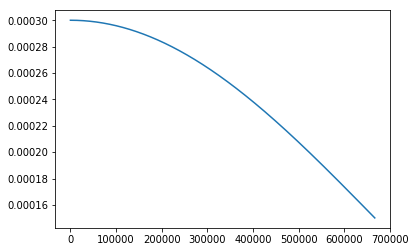

WARNING! Re-Initialize scheduler and optimizer.
WARNING! Re-Initialize scheduler and optimizer.
WARNING! Re-Initialize scheduler and optimizer.


In [32]:
print("WARNING! Re-Initialize scheduler and optimizer.")
print("WARNING! Re-Initialize scheduler and optimizer.")
print("WARNING! Re-Initialize scheduler and optimizer.")
lrs = []
for epoch in range(epochs):
    for idx in range(len(train_loader)):
        lr = scheduler.get_lr()
        scheduler.step(epoch + idx/len(train_loader))
        lrs.append(lr)
plt.plot(lrs)
plt.show()
print("WARNING! Re-Initialize scheduler and optimizer.")
print("WARNING! Re-Initialize scheduler and optimizer.")
print("WARNING! Re-Initialize scheduler and optimizer.")

In [42]:
train_zc, val_zc = None, None
train_losses = []
val_losses = []
train_wrmsses = []
val_wrmsses = []

for epoch in tqdm(range(epochs)):
    train_loss, val_loss = 0, 0
    train_rmse = 0
    #Training phase
    ypreds = [] 
    ytrue = []
    bar = tqdm(train_loader)
    for i, (x, idx, y) in enumerate(bar):
        optimizer.zero_grad()
        out = model(x)
#         loss = criterion(out, y, idx)   
        loss = criterion(out, y)   
        loss.backward()
        optimizer.step()
        scheduler.step(epoch + i/len(train_loader))
        
        with torch.no_grad():
            train_loss += loss.item()/len(train_loader)
            ypreds = out.detach().cpu().numpy().flatten()
            ytrue = y.cpu().numpy().flatten()
            train_rmse += rmse_metric_npy(ypreds, ytrue)/len(train_loader)
            bar.set_description(f"{loss.item():.3f}")
    
    train_wrmsse = 0.5 #whatever
    print(f"[Train] Epoch: {epoch} | Loss: {train_loss:.4f} | RMSE: {train_rmse:.4f}")
    
    #Validation phase      
    with torch.no_grad():
                ytrue = []
                ypreds = []

                for i, (x, idx, y) in enumerate(val_loader):                
                    out = model(x)
#                     loss = criterion(out, y, idx)   
                    loss = criterion(out, y)   
                    val_loss += loss.item()/len(val_loader)
                    ypreds += list(out.detach().cpu().numpy().flatten())
                    ytrue += list(y.cpu().numpy().flatten())

                rrmse = rmse_metric(ypreds, ytrue)
                val_wrmsse, lws = wrmsse_metric(ypreds, ytrue, roll_mat_csr=roll_mat_csr, sw=sw, score_only=False)

                if val_zc is None:
                    val_zc = zero_percentage(ytrue) 
                zc = zero_percentage(ypreds)

                print(f"[Valid] Epoch: {epoch} | Loss: {val_loss:.4f} | RMSE: {rrmse:.4f} | zc: ({zc:.3f}/{val_zc:.3f}) | wrmsse: {val_wrmsse:.4f}")
                print(lws)

    train_losses.append(train_loss)    
    val_losses.append(val_loss)     
    train_wrmsses.append(train_wrmsse)
    val_wrmsses.append(val_wrmsse)
    save(model, f"{model_name}_{epoch}")


[Train] Epoch: 0 | Loss: 2.1170 | RMSE: 2.1170
[Valid] Epoch: 0 | Loss: 1.9790 | RMSE: 2.2025 | zc: (0.681/0.544) | wrmsse: 1.0331
[1.1579182  0.15811094 0.08002508 0.2553747  0.1706825  0.18878523
 0.21044599 0.24284018 0.2761703  0.31034526 0.34482764 0.37931035]



[Train] Epoch: 1 | Loss: 2.0031 | RMSE: 2.0031
[Valid] Epoch: 1 | Loss: 2.0021 | RMSE: 2.2500 | zc: (0.662/0.544) | wrmsse: 0.7804
[0.48888717 0.09106346 0.07473335 0.18044752 0.15540609 0.18143039
 0.20896878 0.24231911 0.2760761  0.31034526 0.34482764 0.37931035]



[Train] Epoch: 2 | Loss: 1.9548 | RMSE: 1.9548
[Valid] Epoch: 2 | Loss: 2.0199 | RMSE: 2.2830 | zc: (0.667/0.544) | wrmsse: 0.7977
[0.4578484  0.08861425 0.07512995 0.17143718 0.15516279 0.18067031
 0.20897416 0.24229652 0.27608553 0.31034528 0.34482764 0.37931035]



[Train] Epoch: 3 | Loss: 1.9197 | RMSE: 1.9197
[Valid] Epoch: 3 | Loss: 2.0032 | RMSE: 2.2530 | zc: (0.683/0.544) | wrmsse: 0.9211
[0.90910136 0.13283928 0.07782965 0.23260129 0.16412324 0.18642994
 0.20983462 0.24266129 0.27612803 0.31034525 0.34482764 0.37931035]



[Train] Epoch: 4 | Loss: 1.8940 | RMSE: 1.8940
[Valid] Epoch: 4 | Loss: 2.0186 | RMSE: 2.2806 | zc: (0.667/0.544) | wrmsse: 0.7959
[0.54420638 0.09642776 0.07504975 0.19241398 0.15696328 0.18258707
 0.20912265 0.24240243 0.27608374 0.31034529 0.34482765 0.37931035]



[Train] Epoch: 5 | Loss: 1.8721 | RMSE: 1.8721
[Valid] Epoch: 5 | Loss: 2.0176 | RMSE: 2.2865 | zc: (0.669/0.544) | wrmsse: 0.7466
[0.41129691 0.08698823 0.07419389 0.16503502 0.15238094 0.18024745
 0.20875739 0.24218335 0.27605427 0.31034525 0.34482764 0.37931035]



[Train] Epoch: 6 | Loss: 1.8532 | RMSE: 1.8532
[Valid] Epoch: 6 | Loss: 2.0310 | RMSE: 2.3069 | zc: (0.642/0.544) | wrmsse: 0.7357
[0.29413998 0.07232341 0.07310855 0.1657262  0.15346628 0.17991379
 0.20875502 0.24217743 0.27605491 0.31034527 0.34482765 0.37931035]



[Train] Epoch: 7 | Loss: 1.8354 | RMSE: 1.8354
[Valid] Epoch: 7 | Loss: 2.0021 | RMSE: 2.2508 | zc: (0.668/0.544) | wrmsse: 0.7919
[0.53524945 0.09749397 0.07490881 0.18712834 0.15542768 0.18212665
 0.20899464 0.24232787 0.27606932 0.31034526 0.34482764 0.37931035]



[Train] Epoch: 8 | Loss: 1.8204 | RMSE: 1.8204
[Valid] Epoch: 8 | Loss: 1.9957 | RMSE: 2.2422 | zc: (0.662/0.544) | wrmsse: 0.7042
[0.32209683 0.07582664 0.07323563 0.15563203 0.15049031 0.17891967
 0.20849207 0.24207676 0.27603211 0.31034525 0.34482764 0.37931035]



[Train] Epoch: 9 | Loss: 1.8077 | RMSE: 1.8077
[Valid] Epoch: 9 | Loss: 2.0226 | RMSE: 2.2827 | zc: (0.660/0.544) | wrmsse: 0.7022
[0.33683071 0.07418703 0.07332257 0.16066741 0.15008643 0.17919901
 0.20839387 0.24213601 0.27602875 0.31034529 0.34482765 0.37931035]



[Train] Epoch: 10 | Loss: 1.7957 | RMSE: 1.7957
[Valid] Epoch: 10 | Loss: 2.0291 | RMSE: 2.2922 | zc: (0.652/0.544) | wrmsse: 0.6524
[0.18550306 0.06244943 0.07238823 0.13240341 0.14782863 0.17688602
 0.20825446 0.24194727 0.27602168 0.31034531 0.34482765 0.37931035]



[Train] Epoch: 11 | Loss: 1.7848 | RMSE: 1.7848
[Valid] Epoch: 11 | Loss: 2.0225 | RMSE: 2.2830 | zc: (0.663/0.544) | wrmsse: 0.6959
[0.30637245 0.07180109 0.07326256 0.14690618 0.14872393 0.17789609
 0.20828339 0.24203771 0.27602591 0.31034528 0.34482764 0.37931035]



[Train] Epoch: 12 | Loss: 1.7743 | RMSE: 1.7743
[Valid] Epoch: 12 | Loss: 2.0092 | RMSE: 2.2569 | zc: (0.695/0.544) | wrmsse: 0.9408
[0.94366666 0.13275804 0.07811376 0.22634198 0.16262355 0.18546264
 0.20958897 0.24263604 0.27611929 0.31034525 0.34482764 0.37931035]



[Train] Epoch: 13 | Loss: 1.7645 | RMSE: 1.7645
[Valid] Epoch: 13 | Loss: 2.0284 | RMSE: 2.2969 | zc: (0.668/0.544) | wrmsse: 0.7246
[0.38644668 0.07874638 0.07385492 0.1607814  0.15052237 0.17916846
 0.20843449 0.24215371 0.27603731 0.31034528 0.34482765 0.37931035]



[Train] Epoch: 14 | Loss: 1.7561 | RMSE: 1.7561
[Valid] Epoch: 14 | Loss: 2.0321 | RMSE: 2.2937 | zc: (0.685/0.544) | wrmsse: 0.8798
[0.77133101 0.11858176 0.07676905 0.20863756 0.15971302 0.1838062
 0.20934928 0.24246237 0.27609419 0.31034526 0.34482764 0.37931035]



[Train] Epoch: 15 | Loss: 1.7477 | RMSE: 1.7477
[Valid] Epoch: 15 | Loss: 2.0335 | RMSE: 2.3015 | zc: (0.658/0.544) | wrmsse: 0.6995
[0.29977743 0.07272608 0.07294447 0.15700133 0.15042087 0.17900942
 0.20847455 0.24208795 0.27603272 0.3103453  0.34482765 0.37931035]


KeyboardInterrupt: 

In [43]:
# [Train] Epoch: 0 | Loss: 2.7182 | RMSE: 2.9797 | zc: (0.640/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 0 | Loss: 2.3442 | RMSE: 2.8169 | zc: (0.684/0.544) | wrmsse: 1.3076
# [2.10753578 0.25993714 0.08958656 0.45471797 0.21192379 0.20922057
#  0.21467227 0.2447319  0.27654522 0.31034609 0.34482775 0.37931036]

# 1.474: 100%
# 239/239 [01:31<00:00, 2.60it/s]


# [Train] Epoch: 1 | Loss: 2.4495 | RMSE: 2.6683 | zc: (0.659/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 1 | Loss: 2.2380 | RMSE: 2.6480 | zc: (0.606/0.544) | wrmsse: 1.0710
# [0.95436476 0.14874324 0.07970559 0.26767532 0.18002803 0.191739
#  0.21161642 0.24324118 0.2762905  0.31034575 0.34482771 0.37931036]

# 1.565: 100%
# 239/239 [06:18<00:00, 1.59s/it]


# [Train] Epoch: 2 | Loss: 2.3338 | RMSE: 2.5162 | zc: (0.660/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 2 | Loss: 2.1796 | RMSE: 2.5528 | zc: (0.694/0.544) | wrmsse: 1.2141
# [1.82708573 0.22902348 0.08625057 0.36194384 0.19074095 0.19988401
#  0.21254641 0.24382938 0.27635083 0.3103456  0.34482769 0.37931036]

# 1.582: 100%
# 239/239 [01:39<00:00, 2.41it/s]


# [Train] Epoch: 3 | Loss: 2.2453 | RMSE: 2.4197 | zc: (0.662/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 3 | Loss: 2.1339 | RMSE: 2.4776 | zc: (0.643/0.544) | wrmsse: 0.8956
# [0.56030379 0.10468518 0.07631914 0.20161134 0.16246963 0.18462395
#  0.20983267 0.24266924 0.27615998 0.31034544 0.34482767 0.37931036]

# 1.370: 100%
# 239/239 [03:04<00:00, 1.30it/s]


# [Train] Epoch: 4 | Loss: 2.1952 | RMSE: 2.3458 | zc: (0.665/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 4 | Loss: 2.1111 | RMSE: 2.4347 | zc: (0.684/0.544) | wrmsse: 1.0589
# [1.18325934 0.162551   0.08152355 0.26652444 0.17225429 0.19027757
#  0.21067981 0.24313821 0.27622338 0.31034541 0.34482767 0.37931035]

# 1.974: 100%
# 239/239 [01:28<00:00, 2.71it/s]


# [Train] Epoch: 5 | Loss: 2.1581 | RMSE: 2.3025 | zc: (0.663/0.563) | wrmsse: 0.5000
# [Valid] Epoch: 5 | Loss: 2.0924 | RMSE: 2.4039 | zc: (0.662/0.544) | wrmsse: 0.9011
# [0.6532173  0.11190976 0.0772809  0.21625822 0.16256436 0.18559452
#  0.20978355 0.2427701  0.27616014 0.31034542 0.34482767 0.37931035]

# 1.957: 92%
# 219/239 [00:56<00:04, 4.01it/s]

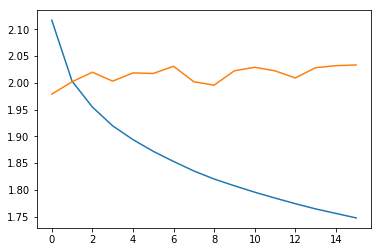

In [44]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

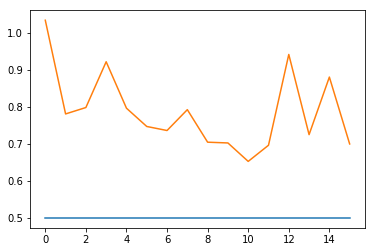

In [45]:
plt.plot(train_wrmsses)
plt.plot(val_wrmsses)
plt.show()

# Get preds

In [46]:
with torch.no_grad():
            ytrue = []
            ypreds = []
            
            for i, (x, idx, y) in enumerate(tqdm(val_loader)):                
                out = model(x)
#                 loss = criterion(out, y, i)   
                loss = criterion(out, y)   
                val_loss += loss.item()/len(val_loader)
                ypreds += list(out.detach().cpu().numpy().flatten())
                ytrue += list(y.cpu().numpy().flatten())
                
            rrmse = rmse_metric(ypreds, ytrue)
            val_wrmsse = wrmsse_metric(ypreds, ytrue, roll_mat_csr=roll_mat_csr, sw=sw)
            
            if val_zc is None:
                val_zc = zero_percentage(ytrue) 
            zc = zero_percentage(ypreds)
            
            print(f"[Valid] Epoch: {epoch} | Loss: {val_loss:.4f} | RMSE: {rrmse:.4f} | zc: ({zc:.3f}/{val_zc:.3f}) | wrmsse: {val_wrmsse:.4f}")


[Valid] Epoch: 16 | Loss: 2.0186 | RMSE: 2.2705 | zc: (0.663/0.544) | wrmsse: 0.6744


In [ ]:
ypreds = load('/home/timetraveller/Work/M5Models/whatever.tmp')
ypreds = np.array(ypreds).reshape(NUM_ITEMS, -1)
print(ypreds.shape)

In [ ]:
submission_df = pd.read_csv("/home/timetraveller/Desktop/kek.csv")
submission_df.iloc[:NUM_ITEMS, 1:] = ypreds

In [ ]:
submission_df.to_csv("/home/timetraveller/Desktop/tch.csv", index=False)

# WRMSSE Analysis

In [ ]:
from typing import Union
df_train_full = pd.read_csv("../new_notebooks_phase2/sales_train_evaluation.csv")
df_train_full.shape

In [ ]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [ ]:
DATA_DIR = "../data/"
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
    
sales = pd.read_csv(DATA_DIR + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})



calendar = pd.read_csv(DATA_DIR + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DATA_DIR + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})
prices = prices.loc[prices.wm_yr_wk >= calendar.wm_yr_wk.values[0], :]

In [ ]:
df_calendar = pd.read_csv("../data/calendar.csv")
df_prices = pd.read_csv("../data/sell_prices.csv")
df_sample_submission = pd.read_csv("../data/sample_submission.csv")
df_sample_submission["order"] = range(df_sample_submission.shape[0])

df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]

evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [ ]:
sub_f = "/home/timetraveller/Desktop/tch.csv"
preds_valid = pd.read_csv(sub_f)
nums = preds_valid.iloc[:30490, 1:]
print((nums < 1).mean().values)
print((nums < 1).mean().values.mean())
nums = evaluator.valid_df[evaluator.valid_target_columns]
print("\n", (nums < 1).mean().values)
print((nums < 1).mean().values.mean())

In [ ]:
preds_valid = pd.read_csv(sub_f)
preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
preds_valid = preds_valid.merge(df_sample_submission[["id", "order"]], on = "id").sort_values("order").drop(["id", "order"], axis = 1).reset_index(drop = True)
preds_valid.rename(columns = {
    "F1": "d_1914", "F2": "d_1915", "F3": "d_1916", "F4": "d_1917", "F5": "d_1918", "F6": "d_1919", "F7": "d_1920",
    "F8": "d_1921", "F9": "d_1922", "F10": "d_1923", "F11": "d_1924", "F12": "d_1925", "F13": "d_1926", "F14": "d_1927",
    "F15": "d_1928", "F16": "d_1929", "F17": "d_1930", "F18": "d_1931", "F19": "d_1932", "F20": "d_1933", "F21": "d_1934",
    "F22": "d_1935", "F23": "d_1936", "F24": "d_1937", "F25": "d_1938", "F26": "d_1939", "F27": "d_1940", "F28": "d_1941"
}, inplace = True)
score = evaluator.score(preds_valid)
print(score)

## Visualize

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [ ]:
create_dashboard(evaluator)